# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Introduction

This post discuss in detail the project "Create a Customer Segmentation Report for Arvato Financial Services", which is one of the Data Scientist's nanodegree capstone options. It is in fact a continuation of a previous project whose solution was posted [here](https://github.com/bvcmartins/dsndProject3). I chose it because of its broad scope which involves a reasonably complex data cleaning procedure, unsupervised learning, analysis of imbalanced data, and prediction using supervised learning tools. In the following I will discuss my solution for it.

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline


from imblearn.over_sampling import SMOTE, SMOTENC

from scipy.stats import ks_2samp
import warnings
import ast
import re

import umap
import xgboost
from xgboost import XGBClassifier


from keras.layers import Input, Dense, Activation
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers import Flatten, Dropout
from keras.layers import Conv2DTranspose, Reshape
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD

from scipy import stats

%matplotlib inline

ModuleNotFoundError: No module named 'tabulate'

In [2]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 500
warnings.filterwarnings('ignore')

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Exploratory Data Analysis

In [3]:
azdias = pd.read_csv('data/azdias.csv')
customers = pd.read_csv('data/customers.csv')
azdias.drop('Unnamed: 0', axis=1, inplace=True)
customers.drop('Unnamed: 0', axis=1, inplace=True)

### Azdias: general population dataset 

In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

The dataset has almost 900k entries and 366 features. 

In [5]:
azdias.shape

(891221, 366)

Most of them are numerical and most of them are ordinal. The integer numbers only represent a label for hierachical categories. Columns marked as float are actually comprised by ints but were marked that way only because they contain NaN, which is itself a float. The latest pandas version allows us to use the type Int64 which supports a integer NaN.

In [6]:
azdias.dtypes

LNR                              int64
AGER_TYP                         int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                  object
CAMEO_DEUG_2015                 object
CAMEO_INTL_2015                 object
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float64
CJT_TYP_2                      float64
CJT_TYP_3                      float64
CJT_TYP_4                

There are also 6 features of type object. These are categorical variables, except for EINGEFUEGT_AM, which is datetime.

In [7]:
azdias.dtypes[azdias.dtypes=='object']

CAMEO_DEU_2015              object
CAMEO_DEUG_2015             object
CAMEO_INTL_2015             object
D19_LETZTER_KAUF_BRANCHE    object
EINGEFUEGT_AM               object
OST_WEST_KZ                 object
dtype: object

Most features contain NaNs which appear in blocks. 

In [8]:
azdias.isnull().values.any()

True

### Customers: current customers dataset

In [9]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

Customers data has three extra columns.

In [10]:
customers.shape

(191652, 369)

These are CUSTOMER_GROUP, ONLINE_PURCHASE, PRODUCT_GROUP

In [11]:
extra_cols = list(set(customers.columns.values).difference(set(azdias.columns.values)))
extra_cols

['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

Two of them are objects and the other is int.

In [12]:
customers.dtypes[extra_cols]

CUSTOMER_GROUP     object
ONLINE_PURCHASE     int64
PRODUCT_GROUP      object
dtype: object

The customers dataframe is also full of NaNs.

In [13]:
customers.isnull().values.any()

True

Attributes [-1,0] indicate missing or unknown

In [14]:
dias_attr = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', skiprows=[0])
dias_attr.drop('Unnamed: 0', axis=1, inplace=True)
dias_attr

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [15]:
dias_info = pd.read_excel('data/DIAS Information Levels - Attributes 2017.xlsx', skiprows=[0])
dias_info.drop('Unnamed: 0', axis=1, inplace=True)
dias_info.replace({'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24':'D19_GESAMT_ANZ_12-24',
                  'D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24':'D19_BANKEN_ ANZ_12-24',
                 'D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24':'D19_TELKO_ ANZ_12-24',
                 'D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24':'D19_VERSI_ ANZ_12-24',
                 'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24':'D19_VERSAND_ ANZ_12-24'},inplace=True)
dias_info

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


Note that features 'EINWOHNER', 'PLZ', 'GKZ', 'PLZ8' are not in azdias

## Data Cleaning

Cleaning this dataset was a relatively complex task. The steps are outlined below:

* pre-cleaning
* converting missing values to NaN
* assessing missing data per feature
* assessing missing data per row
* converting mixed-type features to ordinal or binary features
* one-hot encoding categorical features
* standard scaling numerical features

#### Pre-cleaning

We defined a function to perform general-purpose operations like converting all numeric features to Int64 (support to integer NaN) and make substitutions for some non-standard missing data encodings.

In [16]:
def pre_clean(df):
    list_numeric = df.dtypes[(df.dtypes=='float64') | (df.dtypes=='int64') ].index.values.tolist()
    df[list_numeric] = df[list_numeric].astype('Int64')
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W':0, 'O':1}).astype("Int64")
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace({'XX':np.nan})
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace({'X':np.nan})
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace({'XX':np.nan})
    df['LP_LEBENSPHASE_FEIN'] = df['LP_LEBENSPHASE_FEIN'].replace({0:np.nan}).astype('Int64')
    df['LP_LEBENSPHASE_GROB'] = df['LP_LEBENSPHASE_GROB'].replace({0:np.nan}).astype('Int64')
    return df.drop('EINGEFUEGT_AM', axis=1)

In [17]:
azdias = pre_clean(azdias)

#### Missing Data 

The challenge with this step was that the missing data coding was feature-dependent. Most of the missing values were coded as -1 or 0 and some of them were coded (and not listed in file DIAS) as X or XX. The latter were converted to NaNs during pre-cleaning while the former were first converted to a not-used code (-100) to avoid problems with datatype and then to NaNs.

In [18]:
def map_values(x, dict_missing):
    try:
        return dict_missing[x]
    except:
        return x
    
def missing_values(df):
    missing_df = dias_attr.query('Meaning=="unknown"')[['Attribute','Value']].dropna().set_index('Attribute')
    missing_df = missing_df['Value'].astype('str').str.split(',',expand=True).T
    missing_df = missing_df.applymap(lambda x: int(x) if x!=None else -100)

    for i in missing_df.columns.values:
        for j in [0,1]:
            dict_missing = {missing_df.loc[j,i]:np.nan}
            try:
                df[i] = df[i].map(lambda x: map_values(x, dict_missing)).astype('Int64')
            except:
                pass

    return df

In [19]:
%%time
azdias = missing_values(azdias)

CPU times: user 3min 23s, sys: 692 ms, total: 3min 24s
Wall time: 3min 24s


#### Assess missing data per feature

After having all missing values converted to NaN, we were able to assess which features had more than 445 000, half of the total number of entries, missing. As shown below, we found 9 features satrisfying this requirement. They were all dropped.

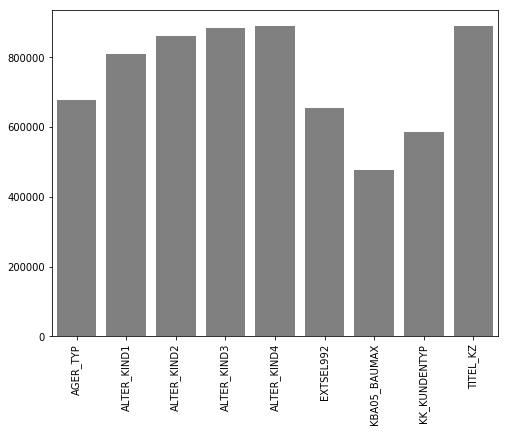

In [20]:
null_df = azdias.isnull().sum()
null_df = null_df[null_df > 445E3]
fig,ax = plt.subplots(figsize=(8,6))
ax = sns.barplot(null_df.index, null_df.values, color='gray')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
ax.set_xlabel('Feature')
az.set_ylabel('Counts')
plt.title('Number of missing entries per feature')
plt.savefig('figures/missing_feature.png')

Dropping these columns we eliminated 18% of all missing values

In [21]:
azdias[null_df.index].isnull().sum().sum() / azdias.isnull().sum().sum()

0.18222273002095582

In [22]:
feature_drop_list = pd.Series(azdias.isnull().sum()).where(lambda x:  x > 445E3).dropna().index.tolist()

['AGER_TYP',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ']

In [23]:
def drop_features(df, feature_drop_list):
    """
    Drops features with too many missing values as listed of feature_drop_list
    """
    return df.drop(feature_drop_list, axis=1)

In [24]:
azdias = drop_features(azdias, feature_drop_list)

### Assess missing data per row

After analyzing missing data per column, we turned our attention to missing values patterns associated with rows. As shown in the figure below, the distribution of missing data per row is multimodal. We selected the leftmost cluster, with values above 180, for a statistical test.

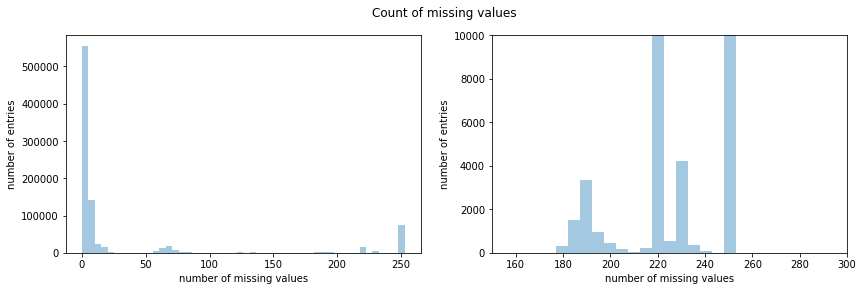

In [25]:
missing_rows = azdias.isnull().sum(axis=1)
fig,ax = plt.subplots(figsize=(14,4), ncols=2, nrows=1)
sns.distplot(missing_rows, kde=False, ax=ax[0])
ax[0].set_xlabel('number of missing values')
ax[0].set_ylabel('number of entries')
ax[0].set_yscale('log')
sns.distplot(missing_rows, kde=False, ax=ax[1])
ax[1].set_xlim([150,300])
ax[1].set_ylim([0,10000])
ax[1].set_yscale('log')
ax[1].set_xlabel('number of missing values')
ax[1].set_ylabel('number of entries');
plt.suptitle('Count of missing values');
plt.savefig('figures/missing_row')

Cutoff for missing values is 180

In [26]:
azdias_below = azdias[azdias.isnull().sum(axis=1)<180].copy().reset_index().drop('index', axis=1)
azdias_above = azdias[azdias.isnull().sum(axis=1)>=180].copy().reset_index().drop('index', axis=1)

The rows with many missing entries can only be used if they have a feature distribution similar to the main data body. To test the hypothesis that both groups have the same distribution, we applied the Kolmogorov-Smirnov test to all numeric columns with no missing data. 

In [27]:
list_numeric = azdias.dtypes[(azdias.dtypes=='int64') | 
                             (azdias.dtypes=='Int64') | 
                             (azdias.dtypes=='float64')].index[1:].tolist()
columns_not_missing = (azdias_above.isnull().sum()==0).index[1:].tolist()
columns_test = set(columns_not_missing).intersection(set(list_numeric))
n_tests = len(columns_test)

In [28]:
ks_df = pd.DataFrame(azdias[columns_test].columns, columns=['col'])
  
def hypothesis_test(df1, df2, cols):
    stats = []
    pvalues = []
    for col in cols:
        counts_main = df1[col].value_counts().sort_index()
        counts_drop = df2[col].value_counts().sort_index()
        try:
            ch = ks_2samp(counts_main, counts_drop)
            stats.append(ch.statistic)
            pvalues.append(ch.pvalue)
        except:
            stats.append(np.nan)
            pvalues.append(np.nan)

    return stats, pvalues

stats, pvalues = hypothesis_test(azdias_below[columns_test], azdias_above[columns_test], azdias_below[columns_test].columns.values)
ks_df['stats'] = stats
ks_df['pvalues'] = pvalues
ks_df.dropna(axis=0, inplace=True)

Because we were executing multiple comparisons, we applied the very strict Bonferroni correction to the p-values.
The results showed that the difference between the two groups were significant only for 8.2% of the test features. Note that this number is not a p-value and it should not be compared with the 0.05 significance level. 

We decided that differences in 8.2% of the test columns was acceptable and we did not drop the rows.

In [29]:
ks_df[ks_df['pvalues']<0.05/n_tests].shape[0] / ks_df.shape[0]

0.08287292817679558

In [ ]:
ks_df['pvalues_corrected'] = ks_df['pvalues'].apply(lambda x: x/n_tests)

Text(0.5, 1.0, 'p-value per column for removed data')

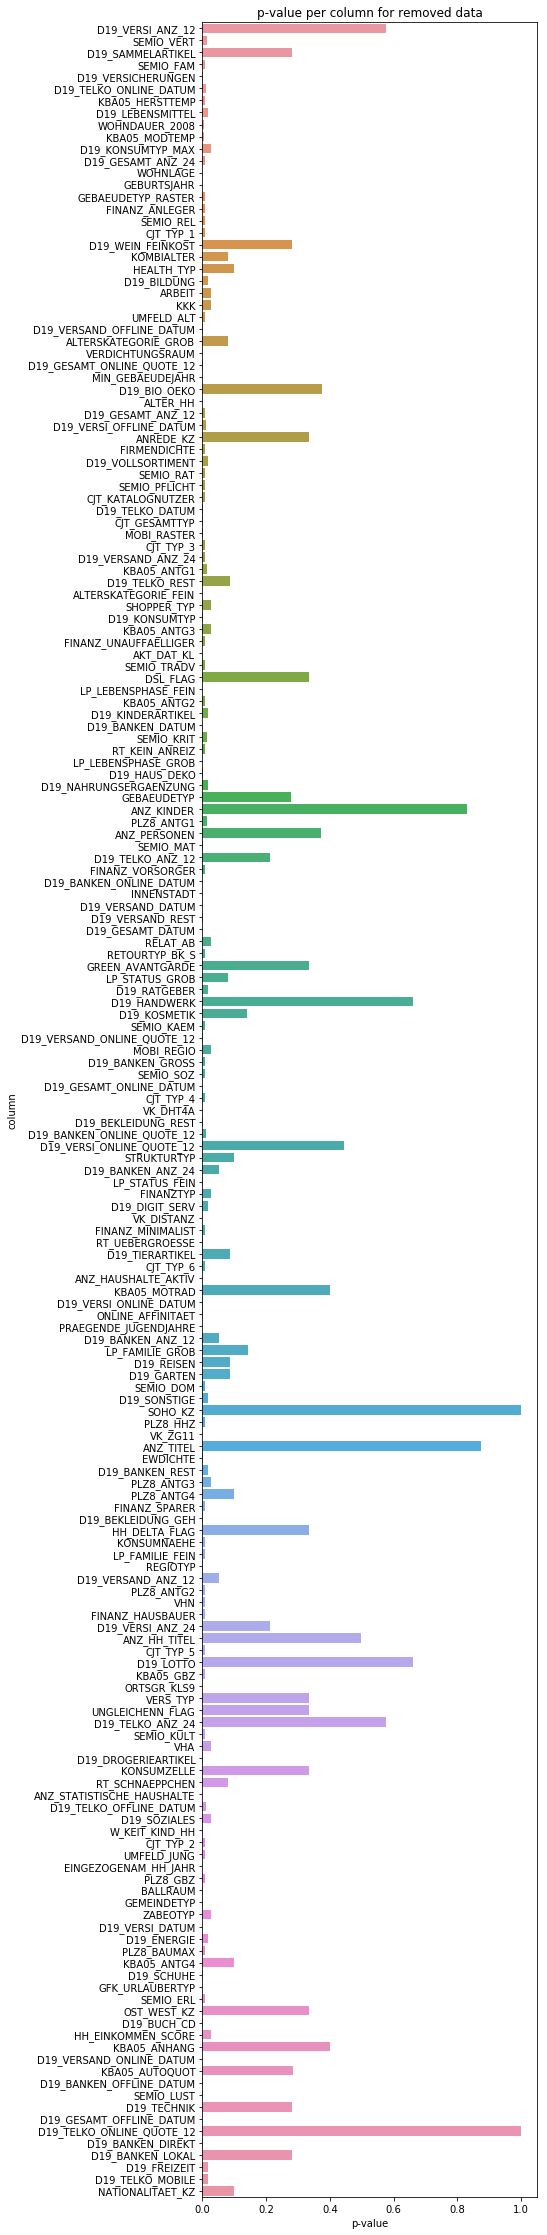

In [30]:
fig,ax = plt.subplots(figsize=(6,40))
sns.barplot(y='col', x='pvalues', data=ks_df, ax=ax)
ax.set_xlabel('p-value')
ax.set_ylabel('column');
ax.set_title('p-value per column for removed data')
plt.title('Bonferroni-corrected p-values for each test column')
plt.savefig('figures/ks_test.png')

### Data Imputation

Imputation was carried out separately for numeric and object variables. Numeric variables were imputed using the median value of the column while object-type variables used the most frequent value.

In [31]:
#impute_estimator = KNeighborsRegressor(n_neighbors=5)
#impute_estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0)
def impute_numeric(df, strategy):
    #imputer = IterativeImputer(random_state=0, estimator=impute_estimator, verbose=2)
    imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputer.fit(df)
    return imputer.transform(df)

def impute_object(df):
    list_mode = df.apply(lambda x: x.mode()[0]).values.tolist()
    list_columns = df.columns.values.tolist()
    dict_mode = {i:j for i,j, in zip(list_columns, list_mode)}
    return df.fillna(value=dict_mode)
    
def impute_calc(df):
    list_numeric = df.dtypes[(df.dtypes=='int64') | 
                             (df.dtypes=='Int64') | 
                             (df.dtypes=='float64')].index[1:].tolist()
    df[list_numeric] = impute_numeric(df[list_numeric].astype('Int64'),'median').astype('int64')
    list_objects = df.dtypes[(df.dtypes=='object')].index.tolist()
    df[list_objects] = impute_object(df[list_objects])
    
    return df

In [32]:
azdias = impute_calc(azdias)

In [33]:
azdias.isnull().values.any()

False

### Re-encode mixed features

After removing all NaNs, the next step was to re-encode the variables of mixed type. These were:

* PRAEGENDE_JUGENDJAHRE
* CAMEO_INTL_2015
* LP_LEBENSPHASE_FEIN
* LP_LEBENSPHASE_GROB

Variable PLZ8_BAUMAX could also have been reencoded but the explanatory gain was too small. In the following we describe each of the variable and how they were transformed.

#### PRAEGENDE_JUGENDJAHRE

Two new attributes were created: PRAGENDE_JUGENDJAHRE_intervall and PRAGENDE_JUGENDJAHRE_trend.

* Levels for PRAGENDE_JUGENDJAHRE_intervall  
    * Dictionary pji_dict
        - 1. 40s
        - 2. 50s
        - 3. 60s
        - 4. 70s
        - 5. 80s
        - 6. 90s

* Levels for PRAGENDE_JUGENDJAHRE_trend
    * Dictionary pjt_dict
        - 0. mainstream
        - 1. avantgarde

In [34]:
def pragende_jugendjahre(df):
    """
    Generare derived variables from mixed type pragende_jugendjahre
    """
    pji_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    pjt_dict = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    df['PRAEGENDE_JUGENDJAHRE_intervall'] = \
    df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pji_dict[int(x)])
    df['PRAEGENDE_JUGENDJAHRE_trend'] = \
    df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pjt_dict[int(x)])
# drop original attribute from dataset
    return df.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

In [35]:
azdias = pragende_jugendjahre(azdias)

#### CAMEO_INTL_2015

Two new attributes were created: CAMEO_INTL_2015_reichtum and CAMEO_INTL_2015_leben

* Levels for CAMEO_INTL_2015_reichtum
    * Dictionary cir_dict
        - 1. Wealthy
        - 2. Prosperous
        - 3. Comfortable
        - 4. Less Affluent
        - 5. Poorer

* Levels for CAMEO_INTL_2015_leben
    * Dictionary cil_dict
        - 1. Pre-Family Couples & Singles
        - 2. Young Couples With Children
        - 3. Families With School Age Children
        - 4. Older Families &  Mature Couples
        - 5. Elders In Retirement

In [36]:
def cameo_intl_2015(df):
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype('int64')
    cir_dict = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 
            35:3, 41:4, 42:4, 43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}
    cil_dict = {11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5, 31:1, 32:2, 33:3, 34:4, 
            35:5, 41:1, 42:2, 43:3, 44:4, 45:5, 51:1, 52:2, 53:3, 54:4, 55:5}
    df['CAMEO_INTL_2015_reichtum'] = df['CAMEO_INTL_2015'].map(cir_dict).astype('int64')
    df['CAMEO_INTL_2015_leben'] = df['CAMEO_INTL_2015'].map(cil_dict).astype('int64')
    return df.drop('CAMEO_INTL_2015', axis=1)

In [37]:
azdias = cameo_intl_2015(azdias)

#### LP_LEBENSPHASE_FEIN

Three new attributes were created: LP_LEBENSPHASE_FEIN_alter, 

#### Levels for LP_LEBENSPHASE_FEIN_alter
#### Dictionary llfa_dict

- 1: young age
- 2: middle age
- 3: retirement age
- 4: advanced age
- 5: higher age

#### Levels for LP_LEBENSPHASE_FEIN_verdiener
#### Dictionary llfv_dict

- 1: low-income earners 
- 2: average earner
- 3: independent
- 4: homeowner
- 5: top earner
- 6: wealthy

#### Levels for LP_LEBENSPHASE_FEIN_familie
#### Dictionary llff_dict

- 1: single
- 2: single parent
- 3: multiperson households
- 4: families
- 5: couples

In [38]:
def lp_lebensphase_fein(df):
    df['LP_LEBENSPHASE_FEIN'] = df['LP_LEBENSPHASE_FEIN'].astype('int64')
    llfa_dict={1:1, 2:2, 3:1, 4:2, 5:4, 6:3, 7:4, 8:3, 9:2, 10:6, 11:4, 12:3, 13:5, 14:1, 15:5, 
           16:5, 17:2, 18:1, 19:5, 20:5, 21:2, 22:2, 23:2, 24:2, 25:2, 26:2, 27:2, 28:2, 29:1, 30:1, 
           31:5, 32:5, 33:1, 34:1, 35:1, 36:5, 37:4, 38:3, 39:2, 40:3}

    llfv_dict={1:1, 2:1, 3:2, 4:2, 5:1, 6:1, 7:2, 8:2, 9:3, 10:3, 11:4, 12:4, 13:5, 14:2, 15:1, 
           16:2, 17:3, 18:6, 19:4, 20:5, 21:1, 22:2, 23:5, 24:1, 25:2, 26:3, 27:4, 28:5, 29:1, 30:2, 
           31:1, 32:2, 33:3, 34:4, 35:5, 36:3, 37:4, 38:4, 39:5, 40:5}

    llff_dict={1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:5, 15:5, 
           16:5, 17:5, 18:5, 19:5, 20:5, 21:2, 22:2, 23:2, 24:4, 25:4, 26:4, 27:4, 28:4, 29:3, 30:3, 
           31:3, 32:3, 33:3, 34:3, 35:3, 36:3, 37:3, 38:3, 39:3, 40:3}

    # transformation of LP_LEBENSPHASE_FEIN
    df['LP_LEBENSPHASE_FEIN_alter'] = df['LP_LEBENSPHASE_FEIN'].map(llfa_dict).astype('int64')
    df['LP_LEBENSPHASE_FEIN_verdiener'] = df['LP_LEBENSPHASE_FEIN'].map(llfv_dict).astype('int64')
    df['LP_LEBENSPHASE_FEIN_familie'] = df['LP_LEBENSPHASE_FEIN'].map(llff_dict).astype('int64')
    # drop original attribute from dataset
    return df.drop('LP_LEBENSPHASE_FEIN', axis=1)



In [39]:
azdias = lp_lebensphase_fein(azdias)

### Mixed-type variable LP_LEBENSPHASE_GROB

#### Three new attributes were created

#### Levels for LP_LEBENSPHASE_GROB_alter:
#### Dictionary llga_dict  
- 1: young age  
- 2: middle age  
- 3: higher age  

#### Levels for LP_LEBENSPHASE_GROB_verdiener:
#### Dictionary llgv_dict  
- 0: low-income and average earner  
- 1: high-income  

#### Levels for LP_LEBENSPHASE_GROB_familie:
#### Dictionary llgf_dict  
- 1: single
- 2: couples
- 3: families
- 4: multiperson
- 5: single parents

In [40]:
def lp_lebensphase_grob(df):
    df['LP_LEBENSPHASE_GROB'] = df['LP_LEBENSPHASE_GROB'].astype('int64')
    llga_dict={1:1, 2:3, 3:2, 4:2, 5:2, 6:2, 7:2, 8:2, 9:1, 10:3, 11:1, 12:3}
    llgv_dict={1:0, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:0, 11:1, 12:1}
    llgf_dict={1:1, 2:1, 3:1, 4:2, 5:2, 6:5, 7:3, 8:3, 9:4, 10:4, 11:4, 12:4}
    
    df['LP_LEBENSPHASE_GROB_alter'] = df['LP_LEBENSPHASE_GROB'].map(llga_dict).astype('int64')
    df['LP_LEBENSPHASE_GROB_verdiener'] = df['LP_LEBENSPHASE_GROB'].map(llgv_dict).astype('int64')
    df['LP_LEBENSPHASE_GROB_familie'] = df['LP_LEBENSPHASE_GROB'].map(llgf_dict).astype('int64')
    # drop original attribute from dataset
    return df.drop('LP_LEBENSPHASE_GROB', axis=1)

In [41]:
azdias = lp_lebensphase_grob(azdias)

### One-hot encoding

The data was cleaned and variables were reencoded. Next we performed one-hot encoding with cardinal variables, the few ones that were encoded as objects or whose integer-encoded levels were not ranked. We also left out binary variables. 

The following variables were one-hot encoded:

* ZABEOTYP
* VERS_TYP
* REGIOTYP
* GFK_URLAUBERTYP
* CJT_GESAMTTYP
* SHOPPER_TYP
* FINANZTYP
* D19_KONSUMTYP
* HEALTH_TYP
* GEBAEUDETYP
* D19_LETZTER_KAUF_BRANCHE
* CAMEO_DEUG_2015
* CAMEO_DEU_201

In [42]:
def make_lists(df):
    list_all = df.columns.tolist()[1:]
    list_onehot = dias_info['Attribute'].str.extract(r'([0-9A-Z_]*TYP)', expand=True).\
    dropna().\
    stack().\
    values.\
    tolist()
    list_onehot = list(set(list_onehot).intersection(set(list_all)))
    list_binary = [column for column in df.columns.tolist() if df[column].value_counts().shape[0]==2]
    #list_onehot = set(list_onehot).difference(set(list_binary))
    list_scale = list(set(list_all).difference(set(list_binary)).difference(set(list_onehot)))
    
    # specific corrections
    list_scale.remove('D19_LETZTER_KAUF_BRANCHE')
    list_onehot.append('D19_LETZTER_KAUF_BRANCHE')
    list_scale.remove('CAMEO_DEUG_2015')
    list_onehot.append('CAMEO_DEUG_2015')
    list_scale.remove('CAMEO_DEU_2015')
    list_onehot.append('CAMEO_DEU_2015')
    
    return list_onehot, list_binary, list_scale

In [43]:
list_onehot, list_binary, list_scale = make_lists(azdias)

In [44]:
def adjust_types(df):
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('int')
    return df.drop('LNR', axis=1)

In [45]:
azdias = adjust_types(azdias)

In [46]:
def onehot_encode(df):
    onehot = OneHotEncoder()
    onehot.fit(df[list_onehot])
    df_onehot = pd.DataFrame(data = onehot.transform(df[list_onehot]).todense(), 
                         columns=onehot.get_feature_names())
    return pd.concat([df.drop(list_onehot, axis=1), df_onehot], axis=1), onehot

def onehot_transform(df):
    df_onehot = pd.DataFrame(data = onehot.transform(df[list_onehot]).todense(), 
                         columns=onehot.get_feature_names())
    return pd.concat([df.drop(list_onehot, axis=1), df_onehot], axis=1)

In [47]:
azdias, onehot = onehot_encode(azdias)

### Scaling

At first Standard Scaler was used but it is was too sensitive to outliers. A combination of Robust scaling with outlier Removal led to improved results.

In [48]:
def scaling(df):
    scaler = RobustScaler()
    df[list_scale] = scaler.fit_transform(df[list_scale])
    return df

In [49]:
azdias = scaling(azdias)

### Removing Outliers

Some of the features had outliers that were skewing the scaling that comes next. Outlier removal was needed at this step to avoid problems with the PCA step. I did some tests with this method in another notebook but it is hard to be absolutely sure that is doing the right thing with such a large dataset.

In [55]:
def remove_outliers(df):
    return df[(np.abs(stats.zscore(df[list_scale])) < 4).all(axis=1)]

In [57]:
azdias = remove_outliers(azdias.copy())

Final result of scaling and outlier removal.

In [60]:
azdias.describe()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINI

### Customer Segmentation Report

The first part of this project analyzed a dataset comprising a sample of the general population of Germany. This dataset will serve as the basis for the prediction analysis that will be carried out below. The analysis comprised the following steps:

1. Reduce dimensionality of the general population dataset
2. Clusterize the reduced space in order to identify customer segments
3. Apply the PCA transformation defined in 1 to the customers dataset
4. Clusterize the customer reduced space and identify which cluster have a population excess

### PCA

After being cleaned and prepared, the dataset had 496 features. Considering that some of these features might be redundant or not important for prediction, it is desirable for a good prediction performance to reduce its dimensionality. We carried this out by applying a PCA transformation and selecting the minimum number of dimensions that cna explain 80% of the variance.

In [61]:
def pca_components(df, minRange, maxRange):
    """
    Iterates through PCA dimensions and generates models
    """
    evr = {}
    for i in range(minRange, maxRange):
        
        pca_model = PCA(n_components=i)
        X_pca = pca_model.fit_transform(df)
        evr[i] = pca_model.explained_variance_ratio_.sum()
    return evr

def generate_pca(df, n_components):
    '''
    Generates PCA model
    
    INPUT: df - scaled dataframe
           n_components - number of components for the model
           
    OUTPUT: pca_model - PCA object
            var_pca - dataframe with components and explained variances
            X_pca - numpy array with transformed data
    '''
    pca_model = PCA(n_components)
    X_pca = pca_model.fit_transform(df)
    components = pd.DataFrame(np.round(pca_model.components_, 4), columns = df.keys())
    ratios = pca_model.explained_variance_ratio_.reshape(len(pca_model.components_),1)
    dimensions = ['Dim {}'.format(i) for i in range(len(pca_model.components_))]
    components.index = dimensions
    variance_ratios = pd.DataFrame(np.round(ratios,4), columns=['Explained_Variance'])
    variance_ratios.index = dimensions
    var_pca = pd.concat([variance_ratios, components], axis=1)
    
    return pca_model, var_pca, X_pca

def transform_pca(df, list_pca, pca_model):
    """
    Transform a dataframe using a previously defined PCA model
    """
    return pca_model.transform(df[list_pca])
    
def scree_plot_pca(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantiating of PCA in scikit learn
            
    OUTPUT: None
    '''
    
    num_comp = len(pca.explained_variance_ratio_)
    idx = np.arange(num_comp)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(16,6))
    ax = plt.subplot(111)
    ax.bar(idx, vals*10)
    ax.plot(idx, np.cumsum(vals),'r--')
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained")
    
    plt.title("Explained Variance per Principal Component")
    plt.savefig('figures/screeplot_pca.png')

Because of its non-statistical nature, PCA analysis is very straightforward and basically only requires us to select the number of dimensions we want to keep. In this case we tested spaces containing between 110 and 120 dimensions and selected 124 dimensions as the minimum number needed to explain 80% of the variance.

In [62]:
evr = pca_components(azdias, 100, 130)

We chose 107 components because it is the smallest number of components for 80% explained variance ratio.

In [63]:
n_dim = [key for key, value in evr.items() if value>=0.8][0]
n_dim

107

In [64]:
n_dim=107
list_pca = azdias.columns.values.tolist()
pca_model, var_pca, df_pca = generate_pca(azdias, n_dim)

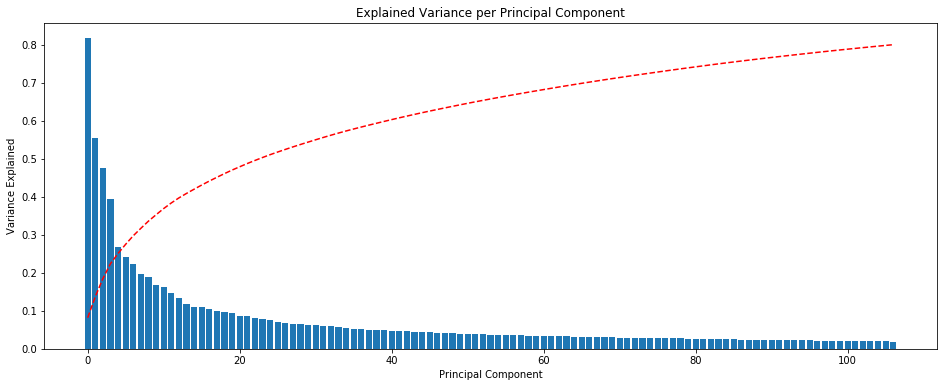

In [65]:
scree_plot_pca(pca_model)

### K-Means

Next, after the space has had its dimensions reduced, we used k-means to generate clusters containing similar instances. This is the basis for the customer segmentation that is carried out using specific customer data. K-means is the most straightforward approach to this problem and it basically requires only the definition of the number of clusters. 

Another option, which might be explored in future versions of this project, is to use dbscan to generate the clusters. Some preliminary testst did not show an improvemetn in prediction, however the non-separable nature of this dataset might profit from a density-cansed approach.

In [66]:
def dist_centroid(X_pca, k_model):
    '''
    Calculates the average distance between points in a certain cluster
    and the cluster centroid.
    
    INPUT: X_pca - transformed PCA dimension
           k_model - instantiated k-means model
           
    OUTPUT: scalar mean distance
    '''
    dist = []
    for i, c in enumerate(k_model.cluster_centers_):
        a = np.array([np.sqrt(np.dot((x - c),(x - c))) for x in X_pca[k_model.labels_ == i]])
        dist.append(a.sum() / (k_model.labels_ == i).sum())
    
    return np.array(dist).mean()

def scree_plot_kmeans(X_pca):
    '''
    Generates scree plot for k-means model
    with 1 to 20 components
    
    INPUT: X_pca - numpy array with transformed data
           
    OUTPUT: scalar mean distance
    '''
    
    k_score = []
    k_dist = []
    k_step = []
    for k in range(5,25):
        k_model = KMeans(n_clusters = k, random_state=34).fit(X_pca)
        a = k_model.score(X_pca)
        k_score.append(a)
        b = dist_centroid(X_pca, k_model)
        print('clusters: {}, score: {}, dist: {}'.format(k, a, b))
        k_dist.append(b)
        k_step.append(k)
        
    return k_step, k_dist, k_score

In [67]:
k_step, k_dist, k_score = scree_plot_kmeans(df_pca)

clusters: 5, score: -111508622.266622, dist: 12.725387500799453
clusters: 6, score: -108963477.38992637, dist: 12.975373645037697
clusters: 7, score: -106911106.75086835, dist: 13.078517720473867
clusters: 8, score: -105182726.35200544, dist: 13.153902387400166
clusters: 9, score: -103976405.58933482, dist: 13.243127073843347
clusters: 10, score: -102909759.33113565, dist: 13.320752737721497
clusters: 11, score: -102090460.7575544, dist: 13.347719951142807
clusters: 12, score: -101366860.09002323, dist: 13.386128763822276
clusters: 13, score: -100707979.0464167, dist: 13.397925106980036
clusters: 14, score: -100082110.4707775, dist: 13.425283984512008
clusters: 15, score: -99513843.32745792, dist: 13.447532468191463
clusters: 16, score: -99047026.25005592, dist: 13.479312225832153
clusters: 17, score: -98592953.73774925, dist: 13.4826335941527
clusters: 18, score: -98199399.90895677, dist: 13.484558321698685
clusters: 19, score: -97795435.31375685, dist: 13.486841920844139
clusters: 20

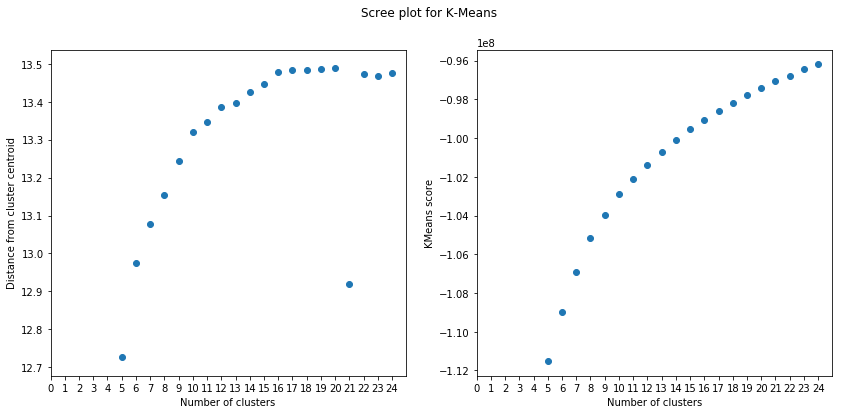

In [68]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].scatter(k_step, k_dist)
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Distance from cluster centroid')
ax[0].set_xticks(np.arange(0, 25, 1.0));
ax[1].scatter(k_step, k_score)
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('KMeans score')
ax[1].set_xticks(np.arange(0, 25, 1.0));
plt.suptitle('Scree plot for K-Means')
plt.savefig('figures/screeplot_kmeans.png')

In [84]:
def calc_clusters(method, X_pca):
    """
    Calculate clusters based on PCA space
    """
    model= method.fit(X_pca)
    df = pd.DataFrame(X_pca)
    df['clusters'] = model.labels_
    
    return df, model

def plot_clusters(df, n_clusters, hue, filename):
    """
    Plot clusters on 2D space spam by the first two PCA axes
    """
    palette = sns.color_palette("Set2", n_clusters).as_hex()
    fig, axis = plt.subplots(1, figsize=(12,10))
    sns.scatterplot(x=0, y=1, data=df, ax=axis, hue=hue, palette=palette)
    axis.set_xlim([-15,20])
    plt.title('Cluster projection on first two PCA axes')
    plt.savefig(filename)

def plot_pops(df, filename):
    """
    Plot relative populations of clusters
    """
    df_ = df['clusters'].value_counts(normalize=True).reset_index()
    sns.barplot(x = 'index', y = 'clusters', data=df_, color='gray')    
    plt.title('Relative cluster populations')
    plt.savefig(filename)
    
def plot_compare_pops(df1, df2, filename):
    df_1 = df1['clusters'].value_counts(normalize=True).reset_index()
    df_2 = df2['clusters'].value_counts(normalize=True).reset_index()
    sns.barplot(x = 'index', y = 'clusters', data=df_1, color='black', alpha=0.2, label='general')    
    sns.barplot(x = 'index', y = 'clusters', data=df_2, color='red', alpha=0.4, label='specific')
    plt.title('Relative cluster populations')
    plt.legend()
    plt.savefig(filename)
    
def transform_kmeans(df_pca, kmeans_model):
    df_kmeans = pd.DataFrame(df_pca)
    df_kmeans['clusters'] = kmeans_model.predict(df_pca)
    return df_kmeans

The scree plot showed that the score started growing linearly at around 12 clusters, which was the number we chose for this analysis. A more formal choice could have used the silhouette score but its high computational cost prevented its use.

In [70]:
n_clusters = 12
general_kmeans, kmeans_model =  calc_clusters(KMeans(n_clusters = n_clusters, random_state=34), df_pca)

With 12 clusters we obatained a approximately balanced cluster population distribution. This is the baseline distribution for the comparison with the customer cluster occupation.

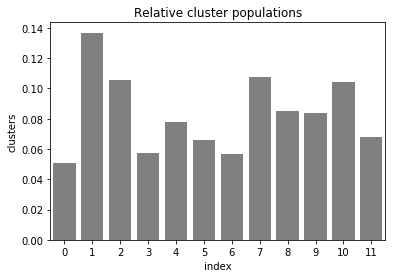

In [71]:
plot_pops(general_kmeans,'figures/general_pop.png')

If we plot the cluster spatial distribution projected on the first two PCA azes we notice that the distribution is a single clusters which is not easily separable. This is not a good case for k-means and probably dbscan would perform better.

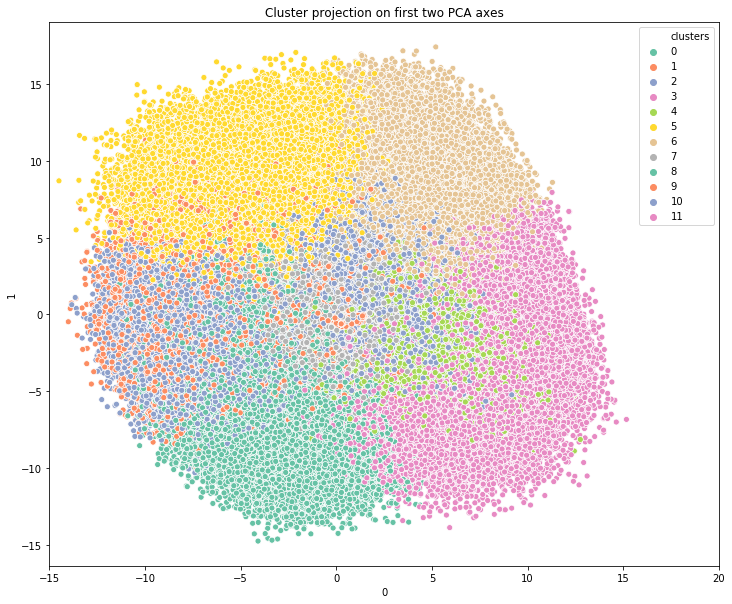

In [85]:
plot_clusters(general_kmeans, n_clusters, 'clusters', 'figures/general_clusters.png')

### Data processing pipeline

K-means is the last step of the data processing pipeline. Now that all the parameters were defined and methods were fitted following the general population distribution, a pipeline was defined to process new datasets.

In [156]:
def pipeline(df):

    df = (df.pipe(pre_clean)
            .pipe(missing_values)
            .pipe(drop_features, feature_drop_list)
            .pipe(impute_calc)
            .pipe(pragende_jugendjahre)
            .pipe(cameo_intl_2015)
            .pipe(lp_lebensphase_fein)
            .pipe(lp_lebensphase_grob)
            .pipe(adjust_types)
            .pipe(onehot_transform)
            .pipe(scaling))

    df_pca = transform_pca(df, list_pca, pca_model)
    df_kmeans = transform_kmeans(df_pca, kmeans_model)
    
    return df, df_kmeans, df_pca

We applied this pipeline to customers, our second dataset, which shows how current company clients are distributed according to the same features present in azdias.

In [157]:
customers_df, customers_kmeans, customers_pca = pipeline(customers.drop(['PRODUCT_GROUP','CUSTOMER_GROUP',
                                                          'ONLINE_PURCHASE'],axis=1).copy())

As shown below, the customers dataset shows a population excess in clusters 1 and 9. This result suggests that every person in azdias that falls in these clusters would have a higher probablility of becoming a client.

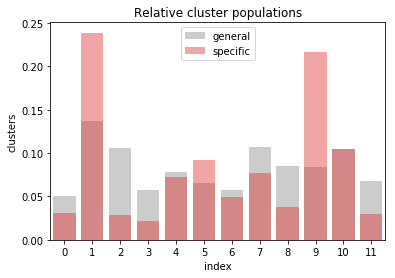

In [158]:
plot_compare_pops(general_kmeans, customers_kmeans, 'figures/customer_clusters.png')

Based on this result it is very straightforward to retrieve the strongest features for each of the clusters and, based on this information, build a profile of the average company customer.

In [281]:
np.arange(0,106,2)

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104])

In [324]:
def plot_kmeans_comps(kmeans_model, cluster_list):
    fig, ax = plt.subplots(len(cluster_list),figsize=(15,8))

    for i, cluster in enumerate(cluster_list):
        sns.barplot(x=np.arange(0,kmeans_model.cluster_centers_[cluster].shape[0]), 
            y=kmeans_model.cluster_centers_[cluster], 
            ax=ax[i], color='blue', alpha=0.6, label=cluster)
        ax[i].set_xlabel('PCA components')
        ax[i].set_ylabel('Component weights')
        ax[i].set_xlim([-0.5,30])
        ax[i].legend()
    plt.suptitle('First 30 PCA component weights'.format(cluster), y=1.02);
    plt.tight_layout()
    plt.savefig('figures/kmeans_comps.png')

The PCA component weights for clusters 1 and 9 is shown below. Note how only the first 10 components are relevant for the description of the cluster.

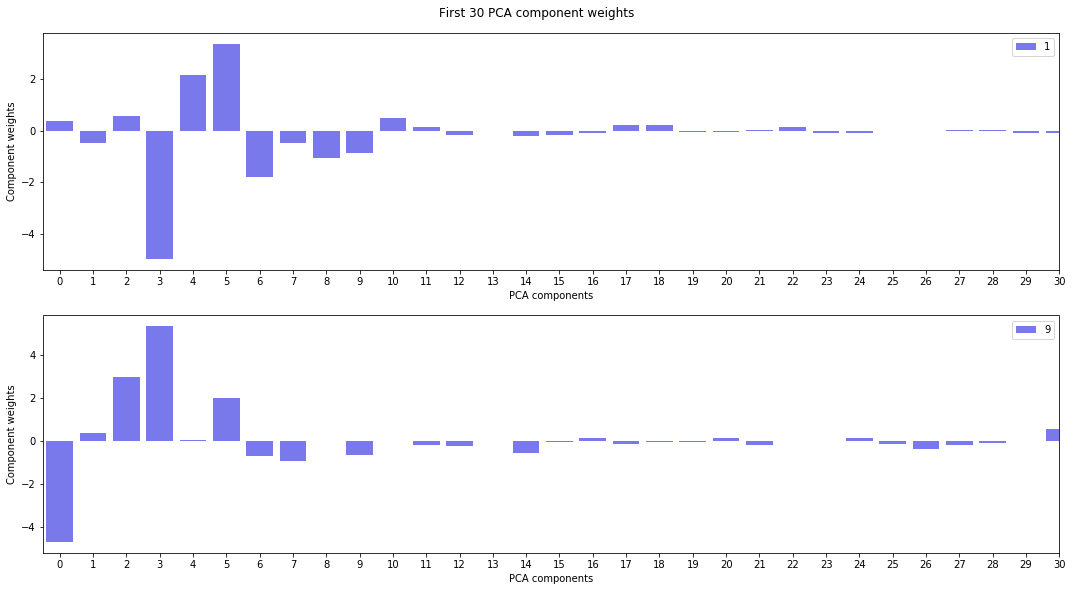

In [325]:
cluster_list = [1,9]
plot_kmeans_comps(kmeans_model, cluster_list)

In [327]:
def comp_analysis(comps, var_pca):
    '''
    Analyze attributes of PCA components for a k-means cluster.
    
    INPUT: comps - list with components
           
    OUTPUT: dataframe 
    '''
    list_df = []
    for i,x in enumerate(comps):
        list_df.append(pd.DataFrame(var_pca.iloc[x,:].sort_values(axis=0, ascending=False)))
        list_df[i]['attribute {}'.format(x)] = list_df[i].index
        list_df[i].set_index(np.arange(var_pca.shape[1]), inplace=True)

    return pd.concat([x for x in list_df],axis=1)

Next we retrieve the original features that are relevant for each cluster given its largest components. 
For example, for cluster 1 we selected components 3, 4, 5 for analysis.

In [331]:
customer_profile_1 = comp_analysis([3,4,5], var_pca)

In [332]:
customer_profile_1.head()

,Dim 3,attribute 3,Dim 4,attribute 4,Dim 5,attribute 5
0,0.1489,GEBURTSJAHR,0.1605,KBA13_KW_61_120,0.2036,KOMBIALTER
1,0.1475,D19_VERSAND_ONLINE_QUOTE_12,0.1542,KBA13_VORB_0,0.1575,SEMIO_KAEM
2,0.1473,D19_GESAMT_ONLINE_QUOTE_12,0.1483,KBA13_KMH_210,0.1567,SEMIO_KRIT
3,0.1455,D19_GESAMT_ANZ_24,0.1357,KBA13_SITZE_5,0.1439,KBA13_CCM_0_1400
4,0.1450,D19_VERSAND_ANZ_24,0.1315,KBA13_CCM_1401_2500,0.1216,SEMIO_DOM


In [333]:
customer_profile_1.tail()

,Dim 3,attribute 3,Dim 4,attribute 4,Dim 5,attribute 5
492,-0.1699,D19_GESAMT_ONLINE_DATUM,-0.1322,KBA13_BJ_1999,-0.1281,VK_DHT4A
493,-0.1735,D19_VERSAND_DATUM,-0.1341,KBA13_KMH_140,-0.1327,KBA13_KW_61_120
494,-0.1819,D19_GESAMT_DATUM,-0.1342,KBA13_SITZE_6,-0.1350,SEMIO_SOZ
495,-0.1835,KOMBIALTER,-0.1621,KBA13_KW_0_60,-0.1456,HH_EINKOMMEN_SCORE
496,-0.1884,D19_KONSUMTYP_MAX,-0.1757,KBA13_BJ_2000,-0.1629,SEMIO_VERT


Given a component we selected the top positive and negative attributes. These two blocks change together and inversely to one another.

Component 3: top 5 positive attributes

1. GEBURTSJAHR
2. D19_VERSAND_ONLINE_QUOTE_12
3. D19_GESAMT_ONLINE_QUOTE_12
4. D19_GESAMT_ANZ_24
5. D19_VERSAND_ANZ_24

Component3: top 5 negative attributes

1. D19_GESAMT_ONLINE_DATUM
2. D19_VERSAND_DATUM 	
3. D19_GESAMT_DATUM
4. KOMBIALTER
5. D19_KONSUMTYP_MAX

Positive attributes depend on age, number of online transactions, transaction activity and MAIL-ORDER transaction activity in the last year. We can suppose that these components are related to online shopping.

Negative attributes depend on actuality of last online transaction and actuality of segment mail-order TOTAL. The last two variables are not in the dictionary. These attributes are harder to interpret but they seem related to actuality of online shopping.

Component 4: top 5 positive attributes

1. KBA13_KW_61_120
2. KBA13_VORB_0
3. KBA13_KMH_210
4. KBA13_SITZE_5 
5. KBA13_CCM_1401_2500

Component 4: top 5 negative attributes

1. KBA13_BJ_1999 	
2. KBA13_KMH_140 	
3. KBA13_SITZE_6
4. KBA13_KW_0_60 
5. KBA13_BJ_2000

All positive and negative features are related to cars. The top 5 are related to larger and newer cars.

Component 5: top 5 positive attributes

1. KOMBIALTER
2. SEMIO_KAEM
3. SEMIO_KRIT
4. KBA13_CCM_0_1400
5. SEMIO_DOM

Component 5: top 5 negative attributes

1. VK_DHT4A
2. KBA13_KW_61_120
3. SEMIO_SOZ
4. HH_EINKOMMEN_SCORE
5. SEMIO_VERT

Positive components are related to personality. They describe someone that is combative, critical-minded and with a dominant personality. These persons also have more potent cars.

Negative components are related to persons with a more community-oriented mind, with lower household incomes and concerned about the environment. These persons also have small cars.

## Supervised Learning Model

The previous part section was aimed at selecting new potential customers that would receive a mailout campaign. The mailout data was split in two approximately equal parts, each with around 43000 entries. One of the blocks is the training set, which contains the same features seen above plus a RESPONSE column which indicates if the person became a customer of the company following the campaign. The other block was used to generate predictions.

In [79]:
mailout_train = pd.read_csv('data/mailout_train.csv')

In [80]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

Training data has around 43 000 entries and 367 features. 

In [81]:
mailout_train.shape

(42962, 367)

As expected for this kind of study, the response classes are very imbalanced. The classes are:

* 0 - did not become customer after campaign
* 1 - became customer after campaign

Only 1.2% of the entries are of class 1.

In [82]:
mailout_train.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [83]:
mailout_train_df, mailout_train_kmeans = pipeline(mailout_train.copy())

In [86]:
mailout_train_df.shape, mailout_train_kmeans.shape

((42962, 497), (42962, 108))

In [91]:
mailout_train_kmeans['RESPONSE'] = mailout_train_df.RESPONSE

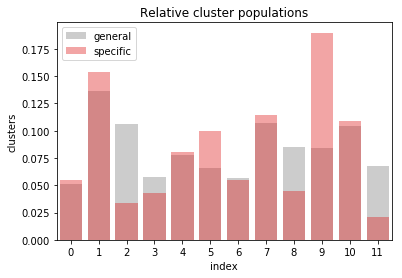

In [92]:
plot_compare_pops(general_kmeans, mailout_train_kmeans.query('RESPONSE==1'), 'figures/mailout_clusters_1.png')

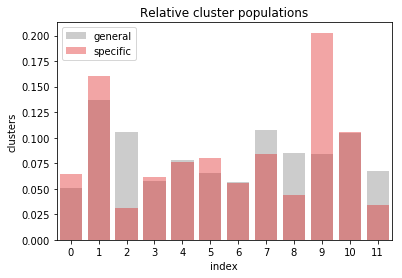

In [93]:
plot_compare_pops(general_kmeans, mailout_train_kmeans.query('RESPONSE==0'), 'figures/mailout_clusters_0.png')

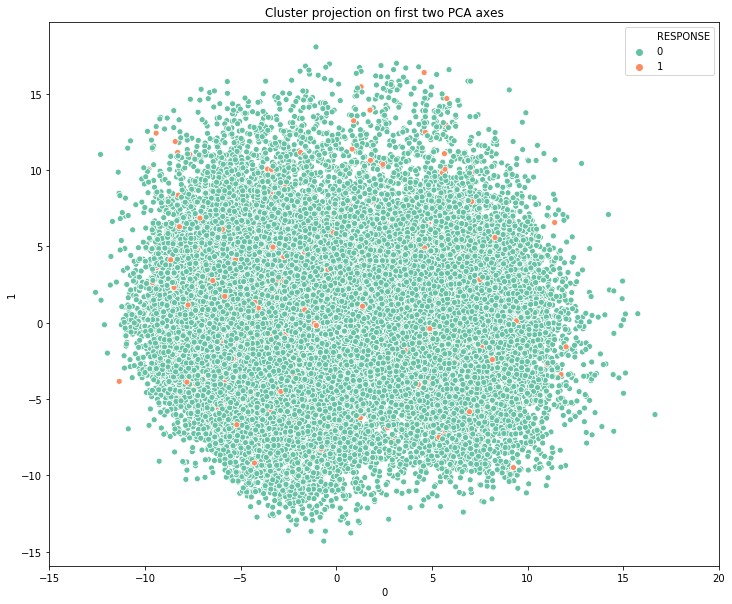

In [96]:
plot_clusters(mailout_train_kmeans, 2, 'RESPONSE', 'figures/mailout_response.png')

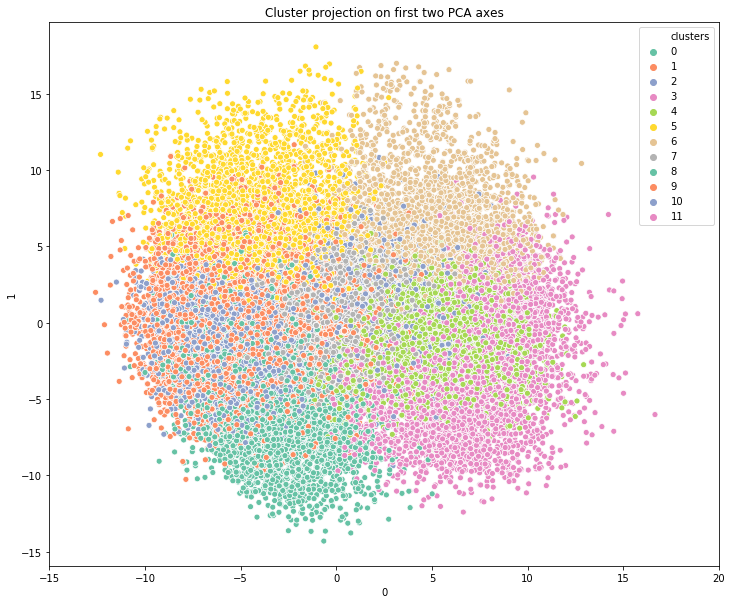

In [97]:
plot_clusters(mailout_train_kmeans, n_clusters, 'clusters', 'figures/mailout_clusters.png')

In [ ]:
#dummies = pd.get_dummies(kmeans_train.clusters, prefix='cluster')
#kmeans_train_extended = pd.concat([kmeans_train.iloc[:,:-2],dummies], axis=1)

In [193]:
y = mailout_train_kmeans.RESPONSE
X = mailout_train_kmeans.drop('RESPONSE', axis=1).copy()

Our first approach to the prediction problem was to apply tree-based methods to the PCA-transformed dataset. In order to add some extra information, we added the cluster number (one-hot encoded) as a feature. Because of the strong class imbalance, we also trained the model using SMOTE-augmented datasets.  

We created a class to take advantage of the namespace, which allows for the separation of similar variables associated with different parameters.

In [270]:
class train_predict_model():
    
    def __init__(self, X, y, model):
        self.X = X
        self.y = y
        self.model = model
        self.train_test()
        
    def train_test(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, 
                                                                                self.y, 
                                                                                test_size=0.33, 
                                                                                shuffle=True, 
                                                                                random_state=34)
        self.X_train = self.X_train.reset_index(drop=True)
        self.y_train = self.y_train.reset_index(drop=True)
        self.X_test = self.X_test.reset_index(drop=True)
        self.y_test = self.y_test.reset_index(drop=True)
    
    def scores(self, labels, preds, preds_proba):
        print('accuracy {}:'.format(self.calc_name), accuracy_score(labels, preds)) 
        print('F1 {}:'.format(self.calc_name),f1_score(labels, preds))
        print('precision {}:'.format(self.calc_name), precision_score(labels, preds))
        print('recall {}:'.format(self.calc_name), recall_score(labels, preds))
        print('auc {}:'.format(self.calc_name), roc_auc_score(labels, np.vstack(preds_proba)[:,1]))
        display(confusion_matrix(labels, preds))
  
    def test_model(self):
        self.y_preds = self.model.predict(self.X_test.values)
        self.y_preds_proba = self.model.predict_proba(self.X_test.values)
        self.calc_name = self.calc_name+' Test set' 
        self.scores(self.y_test, self.y_preds, self.y_preds_proba)
    
    def pred_model(self, X_test_ext, y_test_ext):       
        y_preds = self.model.predict(X_test_ext.values)
        y_preds_proba = self.model.predict_proba(X_test_ext.values)
        self.calc_name = 'External Test'
        self.scores(y_test_ext, y_preds, y_preds_proba)
        return y_preds_proba[:,1]

    def _skf(func):
        def wrapper(self):
            self.labels = []
            self.preds = []
            self.preds_proba = []

            skf5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)
            for train_indices, test_indices in skf5.split(self.X_train, self.y_train):
    
                self.X_train_skf = self.X_train.iloc[train_indices,:].values
                self.y_train_skf = self.y_train[train_indices].values
    
                self.X_test_skf = self.X_train.iloc[test_indices,:].values
                self.y_test_skf = self.y_train[test_indices].values
            
                func(self)
            
                self.model.fit(self.X_res, self.y_res)            
                self.labels.extend(self.y_test_skf)
                self.preds.extend(self.model.predict(self.X_test_skf))
                self.preds_proba.extend(np.array(self.model.predict_proba(self.X_test_skf)))
            self.scores(self.labels, self.preds, self.preds_proba)
            self.test_model()
        return wrapper

    @_skf
    def cv_noSMOTE(self):
        self.X_res = self.X_train_skf
        self.y_res = self.y_train_skf
        self.calc_name = 'no_SMOTE'
    
    @_skf
    def cv_SMOTE(self):
        self.sm = SMOTE(random_state=34)
        self.X_res, self.y_res = self.sm.fit_resample(self.X_train_skf, self.y_train_skf)
        self.calc_name = 'SMOTE'
 

### We first explored three basic models with no optimization

#### Model 1: basic AdaBoostClassifier with no optimization

In [267]:
model1 = train_predict_model(X, y, AdaBoostClassifier(random_state=34))
model1.cv_noSMOTE()
model1.cv_SMOTE()

accuracy no_SMOTE: 0.986798221234019
F1 no_SMOTE: 0.0
precision no_SMOTE: 0.0
recall no_SMOTE: 0.0
auc no_SMOTE: 0.5098336080922948


array([[28404,     8],
       [  372,     0]])

accuracy no_SMOTE Test set: 0.9886443786147553
F1 no_SMOTE Test set: 0.0
precision no_SMOTE Test set: 0.0
recall no_SMOTE Test set: 0.0
auc no_SMOTE Test set: 0.5729648933514053


array([[14017,     1],
       [  160,     0]])

accuracy SMOTE: 0.8051000555864369
F1 SMOTE: 0.028403186698995497
precision SMOTE: 0.015179563124768604
recall SMOTE: 0.22043010752688172
auc SMOTE: 0.5229774277565591


array([[23092,  5320],
       [  290,    82]])

accuracy SMOTE Test set: 0.8008181689942164
F1 SMOTE Test set: 0.03353867214236824
precision SMOTE Test set: 0.01774076755973932
recall SMOTE Test set: 0.30625
auc SMOTE Test set: 0.5593861463832215


array([[11305,  2713],
       [  111,    49]])

In [272]:
model2 = train_predict_model(X, y, RandomForestClassifier(random_state=34))
model2.cv_noSMOTE()
model2.cv_SMOTE()

accuracy no_SMOTE: 0.9870761534185659
F1 no_SMOTE: 0.0
precision no_SMOTE: 0.0
recall no_SMOTE: 0.0
auc no_SMOTE: 0.5025225975999843


array([[28412,     0],
       [  372,     0]])

accuracy no_SMOTE Test set: 0.9887149104246015
F1 no_SMOTE Test set: 0.0
precision no_SMOTE Test set: 0.0
recall no_SMOTE Test set: 0.0
auc no_SMOTE Test set: 0.5024343700955913


array([[14018,     0],
       [  160,     0]])

accuracy SMOTE: 0.954523346303502
F1 SMOTE: 0.026765799256505574
precision SMOTE: 0.018499486125385406
recall SMOTE: 0.04838709677419355
auc SMOTE: 0.5109156607309648


array([[27457,   955],
       [  354,    18]])

accuracy SMOTE Test set: 0.9625476089716463
F1 SMOTE Test set: 0.029250457038391225
precision SMOTE Test set: 0.020671834625323
recall SMOTE Test set: 0.05
auc SMOTE Test set: 0.5257947371236982


array([[13639,   379],
       [  152,     8]])

In [271]:
model3 = train_predict_model(X, y,  XGBClassifier(random_state=34))
model3.cv_noSMOTE()
model3.cv_SMOTE()

accuracy no_SMOTE: 0.9870761534185659
F1 no_SMOTE: 0.0
precision no_SMOTE: 0.0
recall no_SMOTE: 0.0
auc no_SMOTE: 0.5249940298586543


array([[28412,     0],
       [  372,     0]])

accuracy no_SMOTE Test set: 0.9887149104246015
F1 no_SMOTE Test set: 0.0
precision no_SMOTE Test set: 0.0
recall no_SMOTE Test set: 0.0
auc no_SMOTE Test set: 0.5688775146240548


array([[14018,     0],
       [  160,     0]])

accuracy SMOTE: 0.8492912729294052
F1 SMOTE: 0.028660994178235557
precision SMOTE: 0.015632633121641426
recall SMOTE: 0.17204301075268819
auc SMOTE: 0.5355050266508623


array([[24382,  4030],
       [  308,    64]])

accuracy SMOTE Test set: 0.8665538157709127
F1 SMOTE Test set: 0.033707865168539325
precision SMOTE Test set: 0.01835372636262514
recall SMOTE Test set: 0.20625
auc SMOTE Test set: 0.5593094592666571


array([[12253,  1765],
       [  127,    33]])

Results were not very compelling. The best optimized model, obtained after running the following Grid Search routine, was an AdaBoost Classifier with learning_rate=1.0 and n_estimators=300.

Grid search with SMOTE requires the use of a SMOTE pipeline. Scoring was roc_auc and we used only 3-fold split to save processing time.

In [ ]:
ab_model = Pipeline([
        ('sampling', SMOTE()),
        ('ab', AdaBoostClassifier())])

parameters = {"ab__learning_rate" : [0.9, 1.0, 1.1, 2.0],
              "ab__n_estimators": [100, 200, 300, 1000]}

kf = StratifiedKFold(n_splits=3)
grid_ab = GridSearchCV(ab_model, parameters, n_jobs=16, cv=kf, scoring='roc_auc', verbose=10)

grid_ab.fit(X, y)

In [273]:
model4 = train_predict_model(X, y, AdaBoostClassifier(random_state=34, learning_rate=1., n_estimators=300))
model4.cv_noSMOTE()
model4.cv_SMOTE()

accuracy no_SMOTE: 0.9856170094496943
F1 no_SMOTE: 0.004807692307692307
precision no_SMOTE: 0.022727272727272728
recall no_SMOTE: 0.002688172043010753
auc no_SMOTE: 0.4963659248174707


array([[28369,    43],
       [  371,     1]])

accuracy no_SMOTE Test set: 0.9875864014670617
F1 no_SMOTE Test set: 0.0
precision no_SMOTE Test set: 0.0
recall no_SMOTE Test set: 0.0
auc no_SMOTE Test set: 0.5468103509773149


array([[14002,    16],
       [  160,     0]])

accuracy SMOTE: 0.863674263479711
F1 SMOTE: 0.026785714285714284
precision SMOTE: 0.014754098360655738
recall SMOTE: 0.14516129032258066
auc SMOTE: 0.5169949865950931


array([[24806,  3606],
       [  318,    54]])

accuracy SMOTE Test set: 0.8799548596416984
F1 SMOTE Test set: 0.043820224719101124
precision SMOTE Test set: 0.024074074074074074
recall SMOTE Test set: 0.24375
auc SMOTE Test set: 0.5815966525181909


array([[12437,  1581],
       [  121,    39]])

Interestingly, the best results were not obtained using SMOTE but using class weights. XGBoost allows for the definition of class weights that can compensate for class imbalance. Model 5 was the best result using the PCA-transformed dataset.

In [274]:
model5 = train_predict_model(X, y, XGBClassifier(random_state=34, max_depth=4, scale_pos_weight=80))
model5.cv_noSMOTE()

accuracy no_SMOTE: 0.8833032240133407
F1 no_SMOTE: 0.02609452015076834
precision no_SMOTE: 0.014624634384140396
recall no_SMOTE: 0.12096774193548387
auc no_SMOTE: 0.5215833855602433


array([[25380,  3032],
       [  327,    45]])

accuracy no_SMOTE Test set: 0.9121878967414304
F1 no_SMOTE Test set: 0.04009252120277564
precision no_SMOTE Test set: 0.022867194371152155
recall no_SMOTE Test set: 0.1625
auc no_SMOTE Test set: 0.5724160454415751


array([[12907,  1111],
       [  134,    26]])

Surprisingly the results with PCA-transformed were worse than the ones obtained using directly the original dataframe. The new X, y matrices are defined below.

In [275]:
y = mailout_train_df.RESPONSE
X = mailout_train_df.drop('RESPONSE', axis=1).copy()

In [276]:
model6 = train_predict_model(X, y,  XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=34,
              reg_alpha=0, reg_lambda=1, sample_pos_weight=80,
              scale_pos_weight=1, seed=34, silent=None, subsample=0.8,
              verbosity=1))
model6.cv_noSMOTE()

accuracy no_SMOTE: 0.9870761534185659
F1 no_SMOTE: 0.0
precision no_SMOTE: 0.0
recall no_SMOTE: 0.0
auc no_SMOTE: 0.769941502076209


array([[28412,     0],
       [  372,     0]])

accuracy no_SMOTE Test set: 0.9887149104246015
F1 no_SMOTE Test set: 0.0
precision no_SMOTE Test set: 0.0
recall no_SMOTE Test set: 0.0
auc no_SMOTE Test set: 0.7665269653302896


array([[14018,     0],
       [  160,     0]])

## Stop here

In [ ]:
model1 = AdaBoostClassifier(random_state=34)
model1 = skf_noSMOTE(X_train2, y_train2, model1)

In [ ]:
model2 = RandomForestClassifier(random_state=34)
model2 = skf_noSMOTE(X_train2, y_train2, model2)

In [ ]:
model3 = XGBClassifier(random_state=34, scale_pos_weight=80)
model3 = skf_noSMOTE(X_train2, y_train2, model3)

In [ ]:
model3b = XGBClassifier( learning_rate = 0.05, 
                        n_estimators = 1000, 
                        n_jobs=-1, 
                        random_state=34, 
                        sample_pos_weight=80)
model3b = skf_noSMOTE(X_train2, y_train2, model3b)

In [ ]:
model3c = XGBClassifier( learning_rate = 0.05, 
                        n_estimators = 1000, 
                        n_jobs=-1, 
                        random_state=34)
model3c = skf_SMOTE(X_train2, y_train2, model3c)

In [ ]:
model3d = XGBClassifier(random_state=34, max_depth=4, scale_pos_weight=80)
model3d = skf_noSMOTE(X_train2, y_train2, model3d)
pred_model(model3d, X_test2, y_test2)

In [ ]:
Xt = df_mailout_train.iloc[:,:-1]
Xt.drop('RESPONSE', axis=1, inplace=True)
yt = kmeans_train.RESPONSE
X_traint, X_testt, y_traint, y_testt = train_test_split(Xt, yt, test_size=0.33, shuffle=True, random_state=34)
model3e = XGBClassifier(random_state=34, max_depth=4, scale_pos_weight=80)
model3e = skf_noSMOTE(X_traint, y_traint.values, model3e)
pred_model(model3e, X_testt, y_testt)

In [ ]:
# training the model
clf_if = IsolationForest(max_samples=100, random_state=34)
clf_if.fit(Xt)

# predictions
outlier_pred = clf_if.predict(Xt)
outlier_pred.shape

In [ ]:
outlier_list = np.where(outlier_pred==-1)
outlier_list = [i for i in outlier_list]

In [ ]:
outlier_list[0]

In [ ]:
Xt2 = Xt.drop(outlier_list[0])
yt2 = yt.drop(outlier_list[0])

In [ ]:
Xt2.shape, Xt.shape

In [ ]:
X_traint, X_testt, y_traint, y_testt = train_test_split(Xt2, yt2, test_size=0.33, shuffle=True, random_state=34)
model3e = XGBClassifier(random_state=34, max_depth=4, scale_pos_weight=80)
model3e = skf_noSMOTE(X_traint, y_traint.values, model3e)
pred_model(model3e, X_testt, y_testt)

In [ ]:

X_traint, X_testt, y_traint, y_testt = train_test_split(Xt, yt, test_size=0.33, shuffle=True, random_state=34)
model3e = XGBClassifier(random_state=34, max_depth=6, learning_rate=0.01, n_estimators=1000, scale_pos_weight=80)
model3e = skf_noSMOTE(X_traint, y_traint.values, model3e)
pred_model(model3e, X_testt, y_testt)

In [ ]:
def skf_SMOTE(X, y, model):
    
    labels = []
    preds = []

    n = 0

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)
    for train_indices, test_indices in skf.split(X, y):

        X_train_skf = X.iloc[train_indices,:]
        y_train_skf = y[train_indices]
    
        X_test_skf = X.iloc[test_indices,:]
        y_test_skf = y[test_indices]
        
        sm = SMOTE(random_state=34)
        X_res, y_res = sm.fit_resample(X_train_skf, y_train_skf)
        
        model.fit(X_res, y_res)
                
        labels.extend(y_res)
        preds.extend(model.predict(X_res))
    
    print('accuracy :', accuracy_score(labels, preds)) 
    print('F1 :',f1_score(labels, preds))
    print('precision :', precision_score(labels, preds))
    print('recall :', recall_score(labels, preds))
    print('auc :', roc_auc_score(labels, preds))
    display(confusion_matrix(labels, preds))
    
    return model

In [ ]:
model4 = AdaBoostClassifier(random_state=34, learning_rate=0.1, n_estimators=100)
model4 = skf_SMOTE(X_train2, y_train2, model4)

In [ ]:
model5 = RandomForestClassifier(random_state=34)
model5 = skf_SMOTE(X_train2, y_train2, model5)

In [ ]:
model6 = XGBClassifier(random_state=34)
model6 = skf_SMOTE(X_train2, y_train2, model6)

In [ ]:
model7 = RandomForestClassifier(random_state=34, n_estimators = 100)
model7 = skf_SMOTE(X_train2, y_train2, model7)

In [ ]:
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
model8 = XGBClassifier(booster='dart', max_depth=6, learning_rate=0.1, n_estimators=200, n_jobs=-1, random_state=34)
model8 = skf_SMOTE(X_train2, y_train2, model8)

In [ ]:
def pred_model(model, X_test, y_test):
    y_preds = model.predict(X_test)
    print('accuracy :', accuracy_score(y_test, y_preds)) 
    print('F1 :',f1_score(y_test, y_preds))
    print('precision :', precision_score(y_test, y_preds))
    print('recall :', recall_score(y_test, y_preds))
    print('auc :', roc_auc_score(y_test, y_preds))
    y_preds_proba = model.predict_proba(X_test)
    print('auc :', roc_auc_score(y_test, y_preds_proba[:,1]))
    display(confusion_matrix(y_test, y_preds))

In [ ]:
y_test.value_counts()

In [ ]:
pred_model(model1, X_test2, y_test2)

In [ ]:
pred_model(model2, X_test2, y_test2)

In [ ]:
pred_model(model3, X_test2, y_test2)

In [ ]:
pred_model(model3b, X_test2, y_test2)

In [ ]:
pred_model(model3c, X_test2.values, y_test2)

In [ ]:
pred_model(model4, X_test2, y_test2)

In [ ]:
pred_model(model5, X_test2, y_test2)

In [ ]:
pred_model(model6, X_test2.values, y_test2)

In [ ]:
pred_model(model7, X_test2, y_test2)

In [ ]:
pred_model(model8, X_test2.values, y_test2)

In [ ]:
model9 = AdaBoostClassifier(random_state=34, learning_rate=0.05, n_estimators=100)
model9 = skf_SMOTE(X_train2, y_train2, model9)
pred_model(model9, X_test2, y_test2)

### Advanced models

In [ ]:
model10 = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=200, n_jobs=-1, random_state=34)
model10 = skf_SMOTE(X_train2, y_train2, model10)
pred_model(model10, X_test2.values, y_test2)

In [ ]:
model11 = AdaBoostClassifier(random_state=34, learning_rate=1., n_estimators=200)
model11 = skf_SMOTE(X_train2, y_train2, model11)
pred_model(model11, X_test2.values, y_test2)

In [ ]:
model11b = AdaBoostClassifier(random_state=34, learning_rate=1., n_estimators=200)
model11b = skf_SMOTE(X_train2b, y_train2b, model11b)
pred_model(model11b, X_test2.values, y_test2)

In [ ]:
model11b = AdaBoostClassifier(random_state=34, learning_rate=1., n_estimators=200)
model11b = skf_noSMOTE(X_train2b, y_train2b, model11b)
pred_model(model11b, X_test2.values, y_test2)

In [ ]:
model11c = AdaBoostClassifier(random_state=34, learning_rate=1., n_estimators=300)
model11c = skf_noSMOTE(X_train2b, y_train2b, model11c)
pred_model(model11c, X_test2.values, y_test2)

In [ ]:
model12 = XGBClassifier(learning_rate=0.01, n_estimators=1000, n_jobs=-1, random_state=34)
model12 = skf_SMOTE(X_train2, y_train2, model12)
pred_model(model12, X_test2.values, y_test2)

### MLP

In [ ]:
input_size = X_train.shape[1]
num_labels = 2
batch_size = 128
class_weight = {0: 1, 1: 78.}
sm = SMOTE(random_state=34)
X_res, y_res = sm.fit_resample(X_train2, y_train2)
y_train3 = to_categorical(y_train2)
y_test3 = to_categorical(y_test2)
X_train3 = np.reshape(X_train2.values, [-1, input_size])
X_test3 = np.reshape(X_test2.values, [-1, input_size])

In [ ]:
dropout=0.6
hidden_units = 256
model = Sequential()
model.add(Dense(hidden_units, input_dim=input_size))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(num_labels))
# this is the output for one-hot vector
model.add(Activation('softmax'))
model.summary()

In [ ]:
epochs = 100
adam = Adam(lr=0.001)
sgd = SGD(lr=0.001, momentum=0., decay=0., nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit(X_train3, y_train3, epochs=epochs, batch_size=batch_size, class_weight = class_weight, 
          validation_data=(X_test3, y_test3))

In [ ]:
def predict_nn(X, y, model):
    
    y_preds = model.predict(X)

    df_pred = pd.DataFrame(y[:,0].astype('int64'), columns=['true'])
    df_pred['true'] = df_pred['true'].apply(lambda x: 0 if x==1 else 1)
    df_pred['preds'] = np.array(y_preds[:,0])
    df_pred['preds'] = df_pred['preds'].apply(lambda x: 1 if x < 0.5 else 0)
    df_pred['preds_proba'] = np.array(y_preds[:,0])

    class0 = df_pred[(df_pred['true']==1) & (df_pred['preds']==1)].shape[0]
    #print(class0)
    all_entries = df_pred.shape[0]
    print(accuracy_score(df_pred['true'], df_pred['preds']))
    print(roc_auc_score(df_pred['true'], df_pred['preds']))
    print(roc_auc_score(df_pred['true'], df_pred['preds_proba']))

In [ ]:
predict_nn(X_test3, y_test3.copy(), model)

In [ ]:
### Using full df

In [ ]:
X2 = df_mailout_train.iloc[:,:-1]
y2 = df_mailout_train.RESPONSE
X_train4, X_test4, y_train4, y_test4 = train_test_split(X2, y2, test_size=0.2, shuffle=True, random_state=34)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('data/mailout_test.csv')
mailout_test.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df_mailout_test, kmeans_test = pipeline(mailout_test.copy())

In [ ]:
dummies = pd.get_dummies(kmeans_test.clusters, prefix='cluster')
kmeans_test_extended = pd.concat([kmeans_test.iloc[:,:-1],dummies], axis=1)
kmeans_test.head()

In [ ]:
y_preds5 = model5.predict_proba(kmeans_test_extended)
#np.bincount(y_preds5)

In [ ]:
sub_df = pd.DataFrame(mailout_test.LNR.tolist(), columns=['LNR'])

In [ ]:
sub_df['RESPONSE'] = y_preds5

In [ ]:
sub_df.to_csv('submission.csv', index=False)

## Code Bank

In [ ]:
#customer = (customer.pipe(pre_clean)
#      .pipe(missing_values)
#      .pipe(drop_features, arg1=445E3)
#      .pipe(drop_rows).pipe(impute_calc)
#      .pipe(pragende_jugendjahre)
#      .pipe(cameo_intl_2015)
#      .pipe(lp_lebensphase_fein)
#      .pipe(lp_lebensphase_grob)
#      .pipe(adjust_types))
#
#def dummies_scale(df):
#    df_onehot = pd.DataFrame(data = onehot.transform(df[list_onehot]).todense(), 
#                         columns=onehot.get_feature_names())
#    df = pd.concat([df.drop(list_onehot, axis=1), df_onehot], axis=1)
#    df[list_scale] = scaler.transform(df[list_scale])
#    return df
#
#dummies_scale(customer)